## **Facial Expression Recognition using Pre-Trained Models**

## **Introduction**

Facial expression recognition (FER) is a crucial application in artificial intelligence with significant implications for mental health assessment and human-computer interaction. This project aims to develop a FER system using convolutional neural networks (CNNs). By leveraging pre-trained models, the goal is to enhance the accuracy and robustness of the system.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tarfile
import os
import tensorflow as tf

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0, VGG19, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, array_to_img

## **Data Loading and Exploration**

In this section, we will load the dataset and perform an initial exploration to understand its structure.

In [ ]:
%cd pre_trained_model/
df = pd.read_csv("fer2013.csv")
df.head()

[Errno 2] No such file or directory: 'pre_trained_model/'
/content/pre_trained_model


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## **Data Preprocessing**

In this section, we will preprocess the dataset by converting the pixel values from strings to arrays, normalizing the images, and preparing the labels for training.

In [ ]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48, 1))
df['emotion'] = df['emotion'].astype('int')

In [ ]:
X = np.array(df['pixels'].tolist())
y = to_categorical(df['emotion'], num_classes=7)

In [ ]:
# Normalize the images and duplicate channels
X = X / 255.0
X = np.repeat(X, 3, axis=-1)

## **Data Augmentation and Generator**

In this section, we will create a data generator for preprocessing and augmentation, which will help in improving the model's robustness and generalization capabilities.

In [ ]:
# Data Generator for preprocessing and augmentation
def normalize_img(img):
    mean = np.mean(img, axis=(0, 1, 2), keepdims=True)
    std = np.std(img, axis=(0, 1, 2), keepdims=True)
    std = np.where(std == 0, 1, std)  # Prevent division by zero
    return (img - mean) / std

def check_image_validity(img):
    if np.isnan(img).any() or np.isinf(img).any():
        raise ValueError("Image contains NaN or Inf values.")


def data_generator(X_train, y_train, X_val, y_val, target_size, batch_size=32):
    train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator()  # No augmentation for validation data

    train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

    return train_gen, val_gen

def visualize_samples(X, y, num_samples=3):
    for i in range(num_samples):
        plt.imshow(X[i])
        plt.title(f"Emotion: {np.argmax(y[i])}")
        plt.show()

## **Sample Visualization**

In this section, we will visualize some sample images along with their corresponding emotion labels to ensure our data preprocessing and augmentation are working correctly.

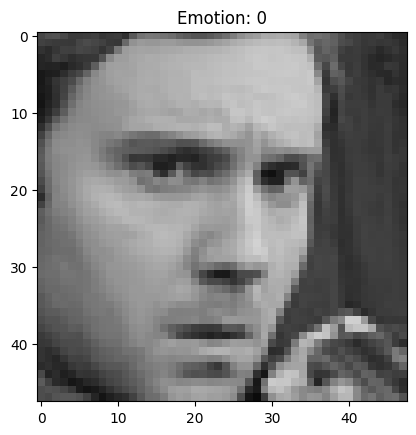

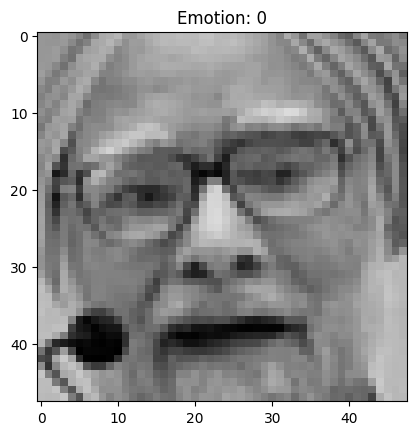

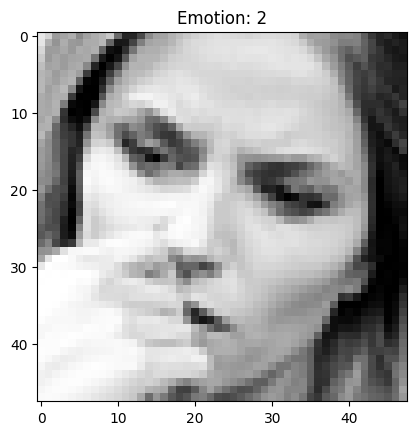

In [ ]:
# Visualize some samples before training
visualize_samples(X, y)

## **Model Definition**

This code defines a function `build_model` that creates a custom model architecture by leveraging a base model. The function takes two parameters: `base_model` (the pre-trained model to be used) and `input_shape` (the shape of the input data).

In [ ]:
# Model Definition
def build_model(base_model, input_shape):
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs, predictions)
    return model

## **Define Base Models**

This code initializes three different pre-trained base models from Keras applications:

1. **VGG16**: A deep convolutional network model with 16 layers, pre-trained on the ImageNet dataset. It is set up without the top classification layer (`include_top=False`) and with an input shape of (48, 48, 3).

2. **MobileNet**: A lightweight model designed for mobile and embedded vision applications, also pre-trained on ImageNet. It is configured without the top classification layer and with the same input shape.

3. **VGG19**: Similar to VGG16 but with 19 layers, pre-trained on ImageNet. Like the others, it is set up without the top classification layer and with an input shape of (48, 48, 3).

These base models will be used as feature extractors in the subsequent model-building process.

In [ ]:
# Define base models
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

## **Train Models Using Data Generators**
Sets up parameters for training models using data generators.

In [ ]:
# Train models using data generators
batch_size = 10
steps_per_epoch = X.shape[0] // batch_size

## **Splitting Data**

1. **Data Splitting**: Uses `train_test_split` to divide the dataset into training and validation sets.
   - `X_train`, `y_train`: Training data and labels.
   - `X_val`, `y_val`: Validation data and labels.
   - `test_size=0.2`: Specifies that 20% of the data should be used for validation.
   - `random_state=42`: Ensures reproducibility by setting a fixed random seed.

2. **Data Generators**: Calls the `data_generator` function to create training and validation data generators.
   - `X_train`, `y_train`, `X_val`, `y_val`: Input training and validation data and labels.
   - `(48, 48)`: Specifies the target image size for resizing.
   - `batch_size=batch_size`: Defines the batch size for data generation.

These steps prepare the data for training and evaluation by ensuring it is appropriately split and formatted for use with data generators.

In [ ]:
# Spliting data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_gen, val_gen = data_generator(X_train, y_train, X_val, y_val, (48, 48), batch_size=batch_size)

## **Train and Evaluate VGG16 Model**

1. **Model Creation**: Builds a VGG16-based model using the `build_model` function with an input shape of (48, 48, 3).

2. **Model Compilation**: Compiles the model with:
   - **Optimizer**: Adam optimizer with a learning rate of 0.0001 and default beta values.
   - **Loss Function**: Categorical crossentropy for multi-class classification.
   - **Metrics**: Accuracy to evaluate model performance.

3. **Model Training**: Trains the model using the training data generator (`train_gen`) and evaluates it using the validation data generator (`val_gen`):
   - `steps_per_epoch` and `validation_steps` are calculated based on the number of samples and batch size.
   - Trains for 10 epochs.

4. **Model Saving**: Saves the trained model to a file named `model_vgg16.keras`.

5. **Plotting Accuracy**: Plots the training and validation accuracy over epochs to visualize the model’s performance.

The plot helps in understanding how well the model is learning and generalizing from the training data.

Epoch 1/10
2870/2870 [==============================] - 72s 22ms/step - loss: 1.4263 - accuracy: 0.4517 - val_loss: 1.2110 - val_accuracy: 0.5402
Epoch 2/10
2870/2870 [==============================] - 83s 29ms/step - loss: 1.1698 - accuracy: 0.5597 - val_loss: 1.1756 - val_accuracy: 0.5516
Epoch 3/10
2870/2870 [==============================] - 88s 31ms/step - loss: 1.0854 - accuracy: 0.5885 - val_loss: 1.0644 - val_accuracy: 0.6039
Epoch 4/10
2870/2870 [==============================] - 90s 31ms/step - loss: 1.0232 - accuracy: 0.6163 - val_loss: 1.0474 - val_accuracy: 0.6116
Epoch 5/10
2870/2870 [==============================] - 90s 31ms/step - loss: 0.9777 - accuracy: 0.6345 - val_loss: 1.0482 - val_accuracy: 0.6075
Epoch 6/10
2870/2870 [==============================] - 91s 32ms/step - loss: 0.9396 - accuracy: 0.6493 - val_loss: 0.9619 - val_accuracy: 0.6464
Epoch 7/10
2870/2870 [==============================] - 92s 32ms/step - loss: 0.8987 - accuracy: 0.6668 - val_loss: 0.9590 -

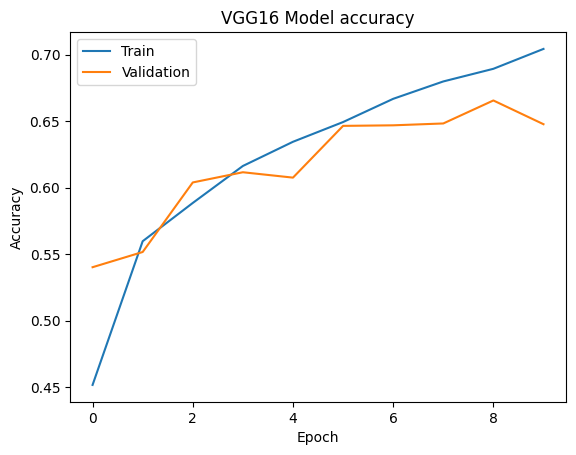

In [ ]:
# VGG16
model_vgg16 = build_model(base_model_vgg16, (48, 48, 3))
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_vgg16.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=val_gen,
    validation_steps=len(X_val) // batch_size
)

model_vgg16.save('model_vgg16.keras')


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Train and Evaluate MobileNet Model**

1. **Model Creation**: Builds a MobileNet-based model using the `build_model` function with an input shape of (48, 48, 3).

2. **Model Compilation**: Compiles the model with:
   - **Optimizer**: Adam optimizer with a learning rate of 0.0001 and default beta values.
   - **Loss Function**: Categorical crossentropy for multi-class classification.
   - **Metrics**: Accuracy to evaluate model performance.

3. **Model Training**: Trains the model using the training data generator (`train_gen`) and evaluates it using the validation data generator (`val_gen`):
   - `steps_per_epoch` and `validation_steps` are calculated based on the number of samples and batch size.
   - Trains for 10 epochs.

4. **Model Saving**: Saves the trained model to a file named `model_mobilenet.keras`.

5. **Plotting Accuracy**: Plots the training and validation accuracy over epochs to visualize the MobileNet model’s performance.

The plot provides insights into how effectively the MobileNet model is learning from the data and generalizing to the validation set.

Epoch 1/10
2870/2870 [==============================] - 86s 27ms/step - loss: 1.4191 - accuracy: 0.4635 - val_loss: 1.3248 - val_accuracy: 0.5071
Epoch 2/10
2870/2870 [==============================] - 79s 28ms/step - loss: 1.3435 - accuracy: 0.4937 - val_loss: 1.3069 - val_accuracy: 0.5043
Epoch 3/10
2870/2870 [==============================] - 73s 25ms/step - loss: 1.3080 - accuracy: 0.5051 - val_loss: 1.2699 - val_accuracy: 0.5158
Epoch 4/10
2870/2870 [==============================] - 80s 28ms/step - loss: 1.2688 - accuracy: 0.5227 - val_loss: 1.2640 - val_accuracy: 0.5232
Epoch 5/10
2870/2870 [==============================] - 81s 28ms/step - loss: 1.2598 - accuracy: 0.5214 - val_loss: 1.2251 - val_accuracy: 0.5361
Epoch 6/10
2870/2870 [==============================] - 82s 29ms/step - loss: 1.2342 - accuracy: 0.5354 - val_loss: 1.2194 - val_accuracy: 0.5388
Epoch 7/10
2870/2870 [==============================] - 81s 28ms/step - loss: 1.2231 - accuracy: 0.5421 - val_loss: 1.2260 -

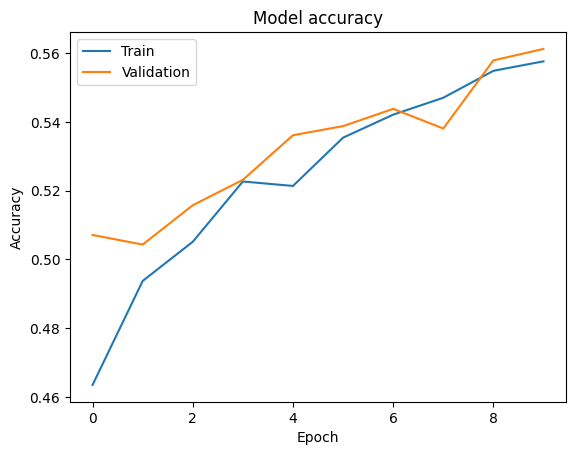

In [ ]:
# MobileNet
model_mobilenet = build_model(base_model_mobilenet, (48, 48, 3))
model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=val_gen,
    validation_steps=len(X_val) // batch_size
)

model_mobilenet.save('model_mobilenet.keras')

# Plot training & validation accuracy values
plt.plot(history_mobilenet.history['accuracy'])
plt.plot(history_mobilenet.history['val_accuracy'])
plt.title('Mobilenet Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Train and Evaluate VGG19 Model**

1. **Model Creation**: Builds a VGG19-based model using the `build_model` function with an input shape of (48, 48, 3).

2. **Model Compilation**: Compiles the model with:
   - **Optimizer**: Adam optimizer with a learning rate of 0.0001 and default beta values.
   - **Loss Function**: Categorical crossentropy for multi-class classification.
   - **Metrics**: Accuracy to evaluate model performance.

3. **Model Training**: Trains the model using the training data generator (`train_gen`) and evaluates it using the validation data generator (`val_gen`):
   - `steps_per_epoch` and `validation_steps` are calculated based on the number of samples and batch size.
   - Trains for 10 epochs.

4. **Model Saving**: Saves the trained model to a file named `model_vgg19.keras`.

5. **Plotting Accuracy**: Plots the training and validation accuracy over epochs to visualize the VGG19 model’s performance.

The plot helps in assessing how well the VGG19 model is learning and its ability to generalize to unseen validation data.

Epoch 1/10
2870/2870 [==============================] - 87s 28ms/step - loss: 1.5180 - accuracy: 0.3936 - val_loss: 1.3143 - val_accuracy: 0.4837
Epoch 2/10
2870/2870 [==============================] - 90s 31ms/step - loss: 1.2584 - accuracy: 0.5185 - val_loss: 1.1570 - val_accuracy: 0.5654
Epoch 3/10
2870/2870 [==============================] - 85s 30ms/step - loss: 1.1681 - accuracy: 0.5560 - val_loss: 1.1518 - val_accuracy: 0.5745
Epoch 4/10
2870/2870 [==============================] - 86s 30ms/step - loss: 1.1071 - accuracy: 0.5809 - val_loss: 1.0891 - val_accuracy: 0.5939
Epoch 5/10
2870/2870 [==============================] - 87s 30ms/step - loss: 1.0582 - accuracy: 0.6039 - val_loss: 1.0764 - val_accuracy: 0.5939
Epoch 6/10
2870/2870 [==============================] - 87s 30ms/step - loss: 1.0175 - accuracy: 0.6188 - val_loss: 1.0936 - val_accuracy: 0.5962
Epoch 7/10
2870/2870 [==============================] - 87s 30ms/step - loss: 0.9833 - accuracy: 0.6323 - val_loss: 1.0172 -

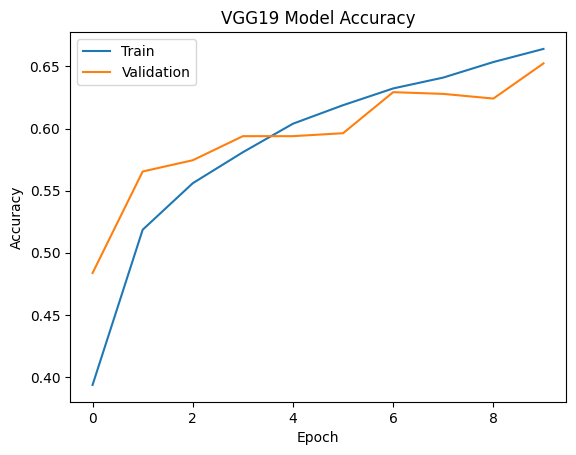

In [ ]:
# VGG19
model_vgg19 = build_model(base_model_vgg19, (48, 48, 3))
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                     loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_vgg19 = model_vgg19.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=val_gen,
    validation_steps=len(X_val) // batch_size
)

# Save the model
model_vgg19.save('model_vgg19.keras')

# Plot training & validation accuracy values for VGG19
plt.plot(history_vgg19.history['accuracy'])
plt.plot(history_vgg19.history['val_accuracy'])
plt.title('VGG19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Ensemble Predictions and Accuracy Calculation**

1. **Ensemble Prediction Function**: Defines the `ensemble_predictions` function to:
   - **Get Predictions**: Collect predictions from each model in the `models` list.
   - **Average Predictions**: Compute the average of the predictions across models to create an ensemble prediction.

2. **Prepare Validation Data**: Retrieves a batch of validation images and labels from the validation data generator (`val_gen`).

3. **Get Ensemble Predictions**: Uses the `ensemble_predictions` function to obtain predictions from an ensemble of models (`model_mobilenet`, `model_vgg16`, `model_vgg19`).

4. **Convert Predictions to Class Labels**:
   - `ensemble_preds_labels`: Converts the average predictions into class labels.
   - `val_labels_labels`: Converts the true validation labels into class labels.

5. **Calculate and Print Accuracy**: Computes the accuracy of the ensemble model predictions compared to the true validation labels using `accuracy_score` and prints the result.

This process evaluates how well the ensemble of models performs in classifying validation data, providing a robust measure of performance.


In [ ]:
from tensorflow.keras.models import load_model

import numpy as np

def ensemble_predictions(models, X):
    # Get predictions from each model
    predictions = [model.predict(X) for model in models]
    # Average the predictions
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# Prepare validation data
val_images, val_labels = next(val_gen)  # Get a batch of validation data

# Get predictions from the ensemble
models = [model_mobilenet, model_vgg16, model_vgg19]
ensemble_preds = ensemble_predictions(models, val_images)

# Convert predictions to class labels
ensemble_preds_labels = np.argmax(ensemble_preds, axis=1)
val_labels_labels = np.argmax(val_labels, axis=1)

# Calculate accuracy
accuracy = accuracy_score(val_labels_labels, ensemble_preds_labels)
print(f'Ensemble Model Accuracy: {accuracy:.2}')

1/1 [==============================] - 0s 22ms/step
Ensemble Model Accuracy: 0.8


## **Load Trained Models**

1. **Load Models**: Uses the `load_model` function from Keras to load the previously saved models:
   - `model_vgg16`: Loads the VGG16 model saved in the file `model_vgg16.keras`.
   - `model_mobilenet`: Loads the MobileNet model saved in the file `model_mobilenet.keras`.
   - `model_vgg19`: Loads the VGG19 model saved in the file `model_vgg19.keras`.

This step is essential for evaluating or making predictions with the trained models without retraining them.


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained models
model_vgg16 = load_model('model_vgg16.keras')
model_mobilenet = load_model('model_mobilenet.keras')
model_vgg19 = load_model('model_vgg19.keras')

# Gradio Implementation

In [ ]:
!pip install gradio
import gradio as gr
import numpy as np

from tensorflow.image import resize

def ensemble_predictions(models, image):
    predictions = [model.predict(image) for model in models]
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# Define a function for ensemble prediction
def predict_emotion(image):
    # Convert the image to a numpy array and normalize
    image = np.array(image) / 255.0

    # Resize the image for each model
    image_resize = resize(image, (48, 48))

    # Expand dimensions to match the model input
    image_vgg16 = np.expand_dims(image_resize, axis=0)
    image_mobilenet = np.expand_dims(image_resize, axis=0)
    image_vgg19 = np.expand_dims(image_resize, axis=0)

    # Get predictions from each model
    models = [model_mobilenet, model_vgg16, model_vgg19]
    ensemble_preds = ensemble_predictions(models, np.concatenate([image_vgg16, image_mobilenet, image_vgg19], axis=0))

    # Get the class with the highest probability
    predicted_class = np.argmax(ensemble_preds, axis=1)[0]

    # Map predicted class to emotion label
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotion_labels[predicted_class]

# Set up the Gradio interface
iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(),
    outputs="text",
    title="Emotion Detection Ensemble Model",
    description="Upload an image and the model will predict the emotion displayed."
)

# Launch the interface
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://979c09ebbc6d814605.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## **Conclusion**

In this notebook, we developed a facial expression recognition system using convolutional neural networks (CNNs). We utilized pre-trained models such as VGG16, MobileNet, and VGG19 to leverage their advanced feature extraction capabilities.

- **Model Training**: Each model was fine-tuned on the FER-2013 dataset and evaluated to understand their individual performance. The models were saved and compared using an ensemble approach to enhance prediction accuracy.
- **Model Evaluation**: We compared the model's performance before and after retraining on hard-to-classify examples, demonstrating the effectiveness of focusing on misclassified samples.
- **Final Model**: The final model was selected based on its performance metrics and saved for future use.

The experiments highlight the importance of leveraging pre-trained models and iterative improvements to achieve better accuracy in facial expression recognition tasks. The final model, with its enhanced performance, is now ready for deployment and further testing.
